In [1]:
from datasets import load_dataset

dataset = load_dataset("wicho/kor_3i4k")
word_list = [item['text'] for item in dataset['train']]

In [3]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# 1. 단어 리스트 로드
dataset = load_dataset("wicho/kor_3i4k")
word_list = [item['text'] for item in dataset['train']]

# 2. 임베딩 모델 준비
model = SentenceTransformer("BAAI/bge-m3", device="cuda")

# 3. 임베딩 생성
batch_size = 32
embeds = []
for i in range(0, len(word_list), batch_size):
    batch = word_list[i:i+batch_size]
    emb = model.encode(batch, batch_size=batch_size, convert_to_numpy=True, normalize_embeddings=True)
    embeds.append(emb)
embeds_np = np.vstack(embeds).astype("float32")

# 4. FAISS 인덱싱 및 저장
dim = embeds_np.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeds_np)
faiss.write_index(index, "korean_words_vector.index")
print(f"저장된 단어 수: {len(word_list)}개, 임베딩 차원: {dim}")


저장된 단어 수: 55134개, 임베딩 차원: 1024


In [ ]:
import faiss
from datasets import load_dataset
import numpy as np
from sentence_transformers import SentenceTransformer
dataset = load_dataset("wicho/kor_3i4k")
word_list = [item['text'] for item in dataset['train']]
# 2. 임베딩 모델 준비
model = SentenceTransformer("BAAI/bge-m3", device="cuda")

# 3. FAISS 인덱스 로드
index = faiss.read_index("korean_words_vector.index")
def find_nearest_words_with_scores(query_word, k=5):
    # 쿼리 임베딩
    query_emb = model.encode([query_word], normalize_embeddings=True).astype("float32")
    # 검색
    D, I = index.search(query_emb, k+1)
    result_words = []
    result_scores = []
    for idx, score in zip(I[0], D[0]):
        if word_list[idx] != query_word:  # 자기 자신 제외
            result_words.append(word_list[idx])
            result_scores.append(score)
        if len(result_words) == k:
            break
    return list(zip(result_words, result_scores))

search_word = "친구"
results = find_nearest_words_with_scores(search_word)
for word, score in results:
    print(f"{word} (유사도: {score:.3f})")

친구가 (유사도: 0.910)
무슨 친구가  (유사도: 0.828)
친구랑도 (유사도: 0.801)
저런 친구 (유사도: 0.790)


In [ ]:
import os
from collections import Counter
import pandas as pd
from tqdm import tqdm
import logging

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('word_freq_debug.log'),
        logging.StreamHandler()
    ]
)

folder_path = r'C:\Users\good1\Desktop\여름방학특별프로젝트\smartnote\testdataset'
word_freq = Counter()

try:
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
except FileNotFoundError:
    logging.error(f"폴더를 찾을 수 없습니다: {folder_path}")
    raise

logging.info(f"총 {len(file_list)}개의 .txt 파일을 처리합니다.")

# 직렬 처리 (파일 하나씩 순차 처리)
for filename in tqdm(file_list, desc="Processing files", unit="file"):
    file_path = os.path.join(folder_path, filename)
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                words = line.strip().split()
                word_freq.update(words)
        logging.info(f"✅ {filename} 처리 완료")
    except Exception as e:
        logging.error(f"❌ {filename} 처리 중 오류 발생: {e}")

# 저장
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'count'])
word_freq_df = word_freq_df.sort_values(by='count', ascending=False).reset_index(drop=True)


print(word_freq_df.head(10))


In [5]:
import re

# 특수문자 제거 함수 (영문, 숫자, 한글만 남김)
def clean_word(word):
    # 원하는 문자만 남김 (한글, 영어, 숫자, 공백은 필요 없으니 제거)
    return re.sub(r'[^가-힣a-zA-Z0-9]', '', word)

# 적용
word_freq_df['clean_word'] = word_freq_df['word'].astype(str).apply(clean_word)

# 소문자 통일 (영어만)
word_freq_df['clean_word'] = word_freq_df['clean_word'].str.lower()

In [ ]:
word_freq_df.drop_duplicates(subset=[word_freq_df.columns[0]], keep='first')

In [ ]:
output_file = 'word_frequency.csv'
word_freq_df.to_csv(output_file, index=False, encoding='utf-8-sig')
logging.info(f"단어 빈도 계산 완료, 총 단어 종류: {len(word_freq)}")
logging.info(f"결과를 {output_file}로 저장했습니다.")

In [2]:
import pandas as pd
data = pd.read_csv('word_frequency.csv', encoding='utf-8-sig')
print(data.shape)

(53478998, 2)


In [7]:
filtered_df = data[data['count'] > 14]

In [11]:
filtered_df['clean_word']

0               다
1               왜
2               이
3              진짜
4               더
            ...  
1754769     같은금액을
1754770    기대할게없는
1754771     모욕당했다
1754772       전사임
1754773       봅아준
Name: clean_word, Length: 1754774, dtype: object

In [9]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# 1. 단어 리스트 로드
word_list = filtered_df['clean_word'].tolist()

# 2. 임베딩 모델 준비
model = SentenceTransformer("BAAI/bge-m3", device="cuda")

# 3. 임베딩 생성
batch_size = 32
embeds = []
for i in range(0, len(word_list), batch_size):
    batch = word_list[i:i+batch_size]
    emb = model.encode(batch, batch_size=batch_size, convert_to_numpy=True, normalize_embeddings=True)
    embeds.append(emb)
embeds_np = np.vstack(embeds).astype("float32")

# 4. FAISS 인덱싱 및 저장
dim = embeds_np.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeds_np)
faiss.write_index(index, "korean_news_words_vector.index")
print(f"저장된 단어 수: {len(word_list)}개, 임베딩 차원: {dim}")


RuntimeError: Error in void __cdecl faiss::write_index(const struct faiss::Index *,struct faiss::IOWriter *,int) at D:\bld\faiss-split_1734665785306\work\faiss\impl\index_write.cpp:407: Error: 'ret == (size * 4)' failed: write error in korean_news_words_vector.index: 4051 != 7187554304 (No space left on device)

In [10]:
faiss.write_index(index, "korean_news_words_vector.index")
print(f"저장된 단어 수: {len(word_list)}개, 임베딩 차원: {dim}")

저장된 단어 수: 1754774개, 임베딩 차원: 1024


In [35]:
import faiss
from datasets import load_dataset
import numpy as np
from sentence_transformers import SentenceTransformer

# 1. 단어 리스트 로드
word_list = filtered_df['clean_word'].tolist()
# 2. 임베딩 모델 준비
model = SentenceTransformer("BAAI/bge-m3", device="cuda")

# 3. FAISS 인덱스 로드
index = faiss.read_index("korean_news_words_vector.index")
def find_nearest_words_with_scores(query_word, k=20):
    # 쿼리 임베딩
    query_emb = model.encode([query_word], normalize_embeddings=True).astype("float32")
    # 검색
    D, I = index.search(query_emb, k+1)
    result_words = []
    result_scores = []
    for idx, score in zip(I[0], D[0]):
        if word_list[idx] != query_word:  # 자기 자신 제외
            result_words.append(word_list[idx])
            result_scores.append(score)
        if len(result_words) == k:
            break
    return list(zip(result_words, result_scores))

search_word = "레바의모험"
results = find_nearest_words_with_scores(search_word)
for word, score in results:
    print(f"{word} (유사도: {score:.3f})")

레베카 (유사도: 0.680)
라바 (유사도: 0.635)
레카는 (유사도: 0.633)
레버가 (유사도: 0.632)
레카 (유사도: 0.627)
리베카가 (유사도: 0.622)
모험의 (유사도: 0.621)
리베카를 (유사도: 0.621)
리베카 (유사도: 0.617)
레가 (유사도: 0.611)
레카가 (유사도: 0.610)
리베카는 (유사도: 0.609)
레기다 (유사도: 0.607)
레야 (유사도: 0.607)
레카기사가 (유사도: 0.601)
렉카새끼들 (유사도: 0.601)
무험의 (유사도: 0.598)
레카를 (유사도: 0.595)
레카충들 (유사도: 0.594)
모험이 (유사도: 0.594)


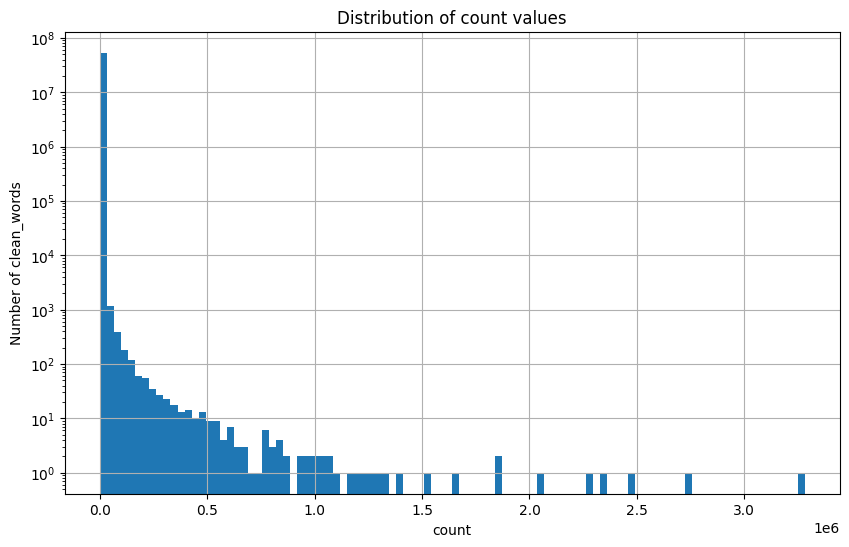

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
data['count'].hist(bins=100, log=True)  # log=True는 skew 줄이기 위해 사용
plt.xlabel('count')
plt.ylabel('Number of clean_words')
plt.title('Distribution of count values')
plt.show()
